In [54]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [55]:
#Load the data

import os

# Define file paths
train_path = os.path.join('..', 'data', 'train.csv')
valid_path = os.path.join('..', 'data', 'validation.csv')
test_path = os.path.join('..', 'data', 'test.csv')

# Save the datasets as CSV files
df_train = pd.read_csv(train_path)
df_valid = pd.read_csv(valid_path)
df_test = pd.read_csv(test_path)


In [56]:
quality_categorical_fun = lambda x: 2 if x>=6 else (1 if x>=5 else 0)

df_train['quality_categorical'] = df_train['quality'].apply(quality_categorical_fun)
df_valid['quality_categorical'] = df_valid['quality'].apply(quality_categorical_fun)
df_test['quality_categorical'] = df_test['quality'].apply(quality_categorical_fun)

In [57]:
# Separate features and targets
X_train, y_train = df_train.drop(['quality','quality_categorical'], axis=1), df_train['quality_categorical']
X_valid, y_valid = df_valid.drop(['quality','quality_categorical'], axis=1), df_valid['quality_categorical']
X_test, y_test = df_test.drop(['quality','quality_categorical'], axis=1), df_test['quality_categorical']

In [58]:
categorical_cols = ["color"]
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

In [59]:
#Create the pipeline
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first"), categorical_cols),
    ("scale", StandardScaler(), numerical_cols)
])

# Create the pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Fit and transform the datasets
X_train = pipeline.fit_transform(X_train)
X_valid = pipeline.transform(X_valid)
X_test = pipeline.transform(X_test)

In [60]:
#Save feature_names for later
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

## Regression problem to predict wine quality

In [61]:
# Initialize multinomial logistic regression
log_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predictions
y_pred_valid = log_reg.predict(X_valid)

# Accuracy
accuracy_valid = accuracy_score(y_valid, y_pred_valid)

print(f"Validation Accuracy: {accuracy_valid:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid))

Validation Accuracy: 0.7278

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.06      0.12        31
           1       0.60      0.56      0.58       219
           2       0.78      0.85      0.81       459

    accuracy                           0.73       709
   macro avg       0.79      0.49      0.50       709
weighted avg       0.73      0.73      0.71       709



In [62]:

# Initialize XGBoost model
xgb_model = XGBClassifier(objective="multi:softmax", num_class=3, eval_metric="mlogloss", random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_valid_xgb = xgb_model.predict(X_valid)

# Accuracy
accuracy_valid_xgb = accuracy_score(y_valid, y_pred_valid_xgb)

print(f"Validation Accuracy: {accuracy_valid_xgb:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_xgb))


Validation Accuracy: 0.7278

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.19      0.27        31
           1       0.58      0.60      0.59       219
           2       0.80      0.83      0.81       459

    accuracy                           0.73       709
   macro avg       0.62      0.54      0.56       709
weighted avg       0.72      0.73      0.72       709



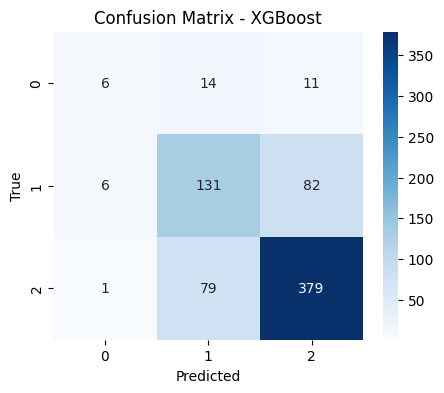

In [63]:
cm_xgb = confusion_matrix(y_valid, y_pred_valid_xgb)

plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_valid), yticklabels=np.unique(y_valid))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - XGBoost")
plt.show()

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions on the validation set
y_pred_valid_rf = rf_model.predict(X_valid)

# Accuracy
accuracy_valid_rf = accuracy_score(y_valid, y_pred_valid_rf)

print(f"Validation Accuracy: {accuracy_valid_rf:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_rf))


Validation Accuracy: 0.7377

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.10      0.17        31
           1       0.61      0.58      0.59       219
           2       0.79      0.86      0.82       459

    accuracy                           0.74       709
   macro avg       0.67      0.51      0.53       709
weighted avg       0.73      0.74      0.72       709



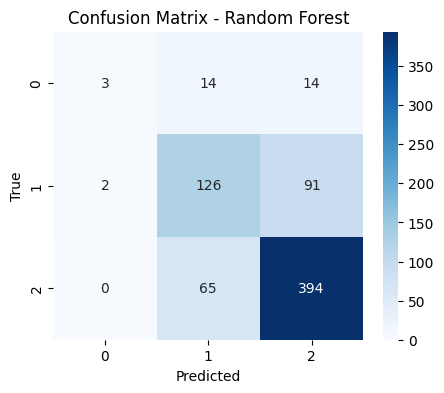

In [65]:
# Confusion Matrix
cm_rf = confusion_matrix(y_valid, y_pred_valid_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_valid), yticklabels=np.unique(y_valid))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest")
plt.show()

C:\Users\giode\AppData\Local\Temp\ipykernel_25280\3675635911.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")


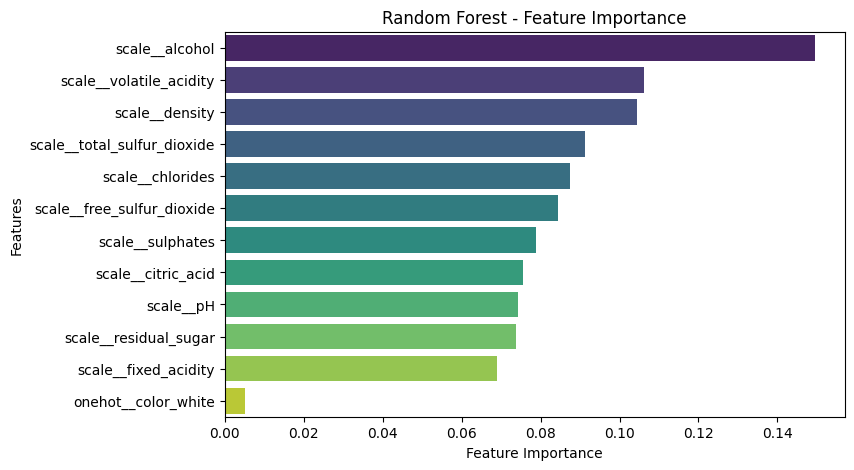

In [67]:
feature_importance = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest - Feature Importance")
plt.show()

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2']  # Features to consider for splits
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, verbose=2, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)


Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\giode\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
324 fits failed out of a total of 972.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\giode\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\giode\anaconda3\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\giode\anaconda3\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\giode\anaconda3\lib\site-packag

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [72]:
# Get the best model
best_rf_model = grid_search.best_estimator_

# Predictions on the validation set
y_pred_valid_rf = best_rf_model.predict(X_valid)

# Accuracy on the validation set
accuracy_valid_rf = accuracy_score(y_valid, y_pred_valid_rf)
print(f"Validation Accuracy: {accuracy_valid_rf:.4f}")

# Classification Report
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_rf))


Validation Accuracy: 0.7489

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.10      0.17        31
           1       0.63      0.60      0.62       219
           2       0.80      0.86      0.83       459

    accuracy                           0.75       709
   macro avg       0.73      0.52      0.54       709
weighted avg       0.74      0.75      0.73       709



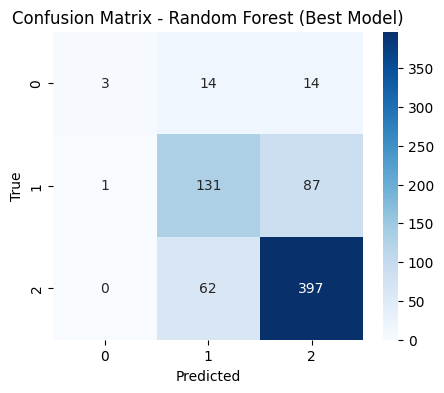

In [73]:
# Confusion Matrix
cm_rf = confusion_matrix(y_valid, y_pred_valid_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_valid), yticklabels=np.unique(y_valid))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Random Forest (Best Model)")
plt.show()